## 标一下24label

In [2]:
import pandas as pd
df = pd.read_csv('model_BERT/complaints.csv')
ids = [24001, 24011, 24015, 24019, 24023, 24024, 24025, 24032, 24033, 24034, 24048, 24052, 24057, 24063, 24071, 24073, 24076, 24078, 24079, 24080, 24081, 24083, 24084, 24088, 24089, 24096, 24098, 24099, 24101, 24102, 24104, 24120, 24121, 24122, 24123, 24134, 24135, 24136, 24138, 24141, 24143, 24146, 24150, 24151, 24152, 24156, 24157]

# 创建新列 'label'，如果complaint_id在列表中则标为1，否则为0
df['label'] = df['complaint_id'].apply(lambda x: 1 if x in ids else 0)

# 保存修改后的DataFrame回到一个新的CSV文件
df.to_csv('complaints_label.csv', index=False)


In [6]:
df = pd.read_csv('complaints_label.csv')

# 需要标记为2的complaint_id列表
ids2 = [24020, 24074, 24077, 24086, 24113, 24114, 24132]

# 使用apply函数和lambda来更新'label'列
df['label'] = df.apply(lambda row: 2 if row['complaint_id'] in ids2 else row['label'], axis=1)

# 覆盖原文件
df.to_csv('complaint_label.csv', index=False)


In [7]:
ids3 = [24002, 24003, 24004, 24005, 24006, 24013, 24029, 24031, 24041, 24047, 24053, 24056, 24059, 24061, 24070, 24087, 24093, 24094, 24095, 24097, 24117, 24127, 24130, 24144, 24147]
ids4 = [24018, 24020, 24036, 24040, 24042, 24054, 24060, 24062, 24064, 24068, 24072, 24075, 24103, 24106, 24107, 24118, 24124, 24125, 24126, 24128, 24137, 24148, 24149, 24153]
ids5 = [24007, 24008, 24009, 24010, 24012, 24014, 24016, 24017, 24021, 24022, 24026, 24027, 24028, 24030, 24035, 24037, 24038, 24039, 24043, 24044, 24045, 24046, 24049, 24050, 24051, 24055, 24058, 24065, 24066, 24067, 24082, 24085, 24087, 24090, 24091, 24092, 24097, 24100, 24105, 24108, 24109, 24110, 24111, 24112, 24115, 24116, 24119, 24129, 24131, 24133, 24139, 24140, 24142, 24145, 24154, 24155]

df = pd.read_csv('complaints_label.csv')

df['label'] = df.apply(lambda row: 3 if row['complaint_id'] in ids3 else (4 if row['complaint_id'] in ids4 else (5 if row['complaint_id'] in ids5 else row['label'])), axis = 1)

df.to_csv('complaint_label.csv', index= False)


label
0      733
1      457
1,4      1
2      130
3       84
4      284
5      185
dtype: int64


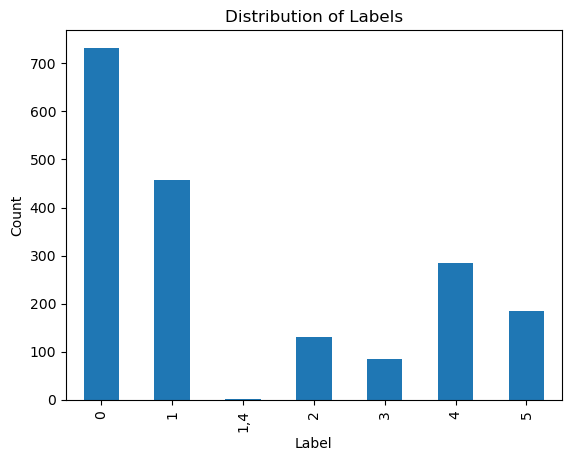

In [2]:
import pandas as pd
df = pd.read_csv('/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/combination_excel_withoutnull_labeled_forjson.csv')
label_distribution = df.groupby('label').size()
print(label_distribution)

import matplotlib.pyplot as plt

# 绘制条形图
label_distribution.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


## 傻呗model

In [16]:
import pandas as pd

# 读取第一个CSV文件（情感数据）
df1 = pd.read_csv('model_BERT/dataset/raw_emotion.csv')

# 读取第二个CSV文件（投诉数据）
df2 = pd.read_csv('complaint_label.csv')

# 重命名第二个DataFrame的列以匹配目标格式
df2 = df2.rename(columns={
    'complaint_id': 'id',
    'complaint': 'text',
    'label': 'target'
})

# 只保留需要的列
df2 = df2[['id', 'text', 'target']]

# 合并两个DataFrame
combined_df = pd.concat([df1, df2], ignore_index=True)

# 保存合并后的数据
combined_df.to_csv('combination.csv', index=False)

print("文件已成功合并并保存为 combination.csv")

文件已成功合并并保存为 combination.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertForSequenceClassification, logging
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm
import logging
import os
from sklearn.metrics import accuracy_score, classification_report

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class EmotionClassifier:
    def __init__(self, model_name='bert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model_name = model_name
        
        # 先读取数据以确定类别数量
        df = pd.read_csv('combination.csv')
        self.num_labels = len(df['target'].unique())
        logger.info(f"检测到 {self.num_labels} 个不同的标签类别")
        self.initialize_model()
        
    def initialize_model(self):
        """初始化新的模型"""
        self.model = BertForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels
        )
        self.model.to(self.device)

    def prepare_dataset(self, texts, labels, max_length=128):
        """将文本转换为模型输入格式"""
        encodings = self.tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        
        dataset = TensorDataset(
            encodings['input_ids'],
            encodings['attention_mask'],
            torch.tensor(labels, dtype=torch.long)  # 确保标签是长整型
        )
        return dataset

    def train_fold(self, train_dataset, val_dataset, fold_idx, 
                  batch_size=16, epochs=3, learning_rate=2e-5,
                  save_dir='model_saves'):
        """训练单个fold"""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
        
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        
        best_val_accuracy = 0
        best_model_path = os.path.join(save_dir, f'best_model_fold_{fold_idx}')
        
        for epoch in range(epochs):
            logger.info(f'Fold {fold_idx + 1} - Epoch {epoch + 1}/{epochs}')
            
            # 训练阶段
            self.model.train()
            train_loss = 0
            train_preds = []
            train_labels = []
            
            progress_bar = tqdm(train_dataloader, desc=f'Training Fold {fold_idx + 1}')
            for batch in progress_bar:
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                labels = batch[2].to(self.device)
                
                optimizer.zero_grad()
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                train_loss += loss.item()
                
                loss.backward()
                optimizer.step()
                
                predictions = torch.argmax(outputs.logits, dim=1)
                train_preds.extend(predictions.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())
                
                # 更新进度条
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}'
                })
            
            # 计算训练指标
            train_accuracy = accuracy_score(train_labels, train_preds)
            avg_train_loss = train_loss / len(train_dataloader)
            
            # 验证阶段
            val_accuracy, val_loss, val_report = self.evaluate(val_dataloader)
            
            logger.info(f'Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')
            logger.info(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')
            logger.info(f'Validation Classification Report:\n{val_report}')
            
            # 保存最佳模型
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                self.save_model(best_model_path)
                logger.info(f'New best model saved for fold {fold_idx + 1} with accuracy: {best_val_accuracy:.4f}')
            
        return best_val_accuracy

    def evaluate(self, dataloader):
        """评估模型"""
        self.model.eval()
        val_loss = 0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                labels = batch[2].to(self.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                val_loss += outputs.loss.item()
                batch_preds = torch.argmax(outputs.logits, dim=1)
                predictions.extend(batch_preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        accuracy = accuracy_score(true_labels, predictions)
        avg_loss = val_loss / len(dataloader)
        classification_rep = classification_report(true_labels, predictions)
        
        return accuracy, avg_loss, classification_rep

    def train_kfold(self, csv_path, n_splits=5, batch_size=16, epochs=3, 
                   learning_rate=2e-5, max_length=128, save_dir='model_saves'):
        """执行K折交叉验证训练"""
        # 读取数据
        df = pd.read_csv(csv_path)
        texts = df['text'].values
        labels = df['target'].values
        
        # 检查并打印标签分布
        unique_labels = np.unique(labels)
        logger.info(f"数据集中的标签类别: {unique_labels}")
        logger.info("标签分布:")
        for label in unique_labels:
            count = np.sum(labels == label)
            logger.info(f"标签 {label}: {count} 个样本 ({count/len(labels)*100:.2f}%)")
        
        # 初始化K折交叉验证
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        fold_scores = []
        
        # 对每个fold进行训练
        for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(texts)):
            logger.info(f'\nTraining Fold {fold_idx + 1}/{n_splits}')
            
            # 准备当前fold的数据
            train_texts, val_texts = texts[train_idx], texts[val_idx]
            train_labels, val_labels = labels[train_idx], labels[val_idx]
            
            # 转换为dataset格式
            train_dataset = self.prepare_dataset(train_texts, train_labels, max_length)
            val_dataset = self.prepare_dataset(val_texts, val_labels, max_length)
            
            # 重新初始化模型
            self.initialize_model()
            
            # 训练当前fold
            best_acc = self.train_fold(
                train_dataset, 
                val_dataset, 
                fold_idx,
                batch_size=batch_size,
                epochs=epochs,
                learning_rate=learning_rate,
                save_dir=save_dir
            )
            
            fold_scores.append(best_acc)
            logger.info(f'Fold {fold_idx + 1} Best Accuracy: {best_acc:.4f}')
        
        # 输出总体结果
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        logger.info(f'\nK-Fold Cross Validation Results:')
        logger.info(f'Mean Accuracy: {mean_score:.4f} (+/- {std_score:.4f})')
        logger.info(f'Individual Fold Scores: {fold_scores}')

    def save_model(self, path):
        """保存模型"""
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)

    def load_model(self, path):
        """加载模型"""
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model.to(self.device)

def main():
    # 设置随机种子
    set_seed(42)
    
    # 初始化分类器
    classifier = EmotionClassifier()
    
    # 开始5折交叉验证训练
    classifier.train_kfold(
        csv_path='combination.csv',
        n_splits=5,
        batch_size=16,
        epochs=3,
        learning_rate=2e-5,
        max_length=128,
        save_dir='model_saves'
    )

if __name__ == "__main__":
    main()

INFO:__main__:检测到 6 个不同的标签类别
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:__main__:数据集中的标签类别: [0 1 2 3 4 5]
INFO:__main__:标签分布:
INFO:__main__:标签 0: 289 个样本 (14.49%)
INFO:__main__:标签 1: 256 个样本 (12.84%)
INFO:__main__:标签 2: 641 个样本 (32.15%)
INFO:__main__:标签 3: 178 个样本 (8.93%)
INFO:__main__:标签 4: 94 个样本 (4.71%)
INFO:__main__:标签 5: 536 个样本 (26.88%)
INFO:__main__:
Training Fold 1/5
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:__main__:Fold 1 - Epoch 1/3
Training Fold 1: 100%|██████████| 100/100